<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# There are many columns with null values but I won't deal this those null values now 
# because I need to sort out the variables which I should focus on in order to build my model
# After sorting out variables, I should focus on data cleaning and feature engineering
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [6]:
# see correlation between SalesPrice and the rest of the features
house_corr = house.corr()
house_corr.iloc[:, 37]

Id              -0.021917
MSSubClass      -0.084284
LotFrontage      0.351799
LotArea          0.263843
OverallQual      0.790982
OverallCond     -0.077856
YearBuilt        0.522897
YearRemodAdd     0.507101
MasVnrArea       0.477493
BsmtFinSF1       0.386420
BsmtFinSF2      -0.011378
BsmtUnfSF        0.214479
TotalBsmtSF      0.613581
1stFlrSF         0.605852
2ndFlrSF         0.319334
LowQualFinSF    -0.025606
GrLivArea        0.708624
BsmtFullBath     0.227122
BsmtHalfBath    -0.016844
FullBath         0.560664
HalfBath         0.284108
BedroomAbvGr     0.168213
KitchenAbvGr    -0.135907
TotRmsAbvGrd     0.533723
Fireplaces       0.466929
GarageYrBlt      0.486362
GarageCars       0.640409
GarageArea       0.623431
WoodDeckSF       0.324413
OpenPorchSF      0.315856
EnclosedPorch   -0.128578
3SsnPorch        0.044584
ScreenPorch      0.111447
PoolArea         0.092404
MiscVal         -0.021190
MoSold           0.046432
YrSold          -0.028923
SalePrice        1.000000
Name: SalePr

In [7]:
# Goals check
# 1.Perform any cleaning, feature engineering, and EDA you deem necessary. -> realted to fixed features
# 4.Train a model on pre-2010 data and evaluate its performance on the 2010 houses -> train/test set split & cv

In [8]:
# Get rid of commercial houses('C') from the dataset(goal 2 check)
house.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [9]:
df = house[house["MSZoning"] != "C (all)"]

In [10]:
df.MSZoning.value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [11]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [12]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1450.000000,1450.000000,1191.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1442.000000,1450.000000,...,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,731.364138,56.903448,70.052897,10523.831724,6.114483,5.582069,1971.593103,1985.049655,104.404300,445.162759,...,94.826897,46.537931,21.536552,3.433103,15.096552,2.777931,43.365517,6.312414,2007.812414,181654.942069
std,421.554345,42.265033,24.301013,10012.185355,1.372860,1.107330,30.022696,20.552319,181.486539,456.353871,...,125.560863,65.222761,60.838826,29.416948,55.893399,40.315051,497.636495,2.698244,1.326321,79176.485241
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000
25%,366.250000,20.000000,59.000000,7544.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,731.500000,50.000000,70.000000,9496.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,384.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163945.000000
75%,1096.750000,70.000000,80.000000,11613.500000,7.000000,6.000000,2001.000000,2004.000000,166.750000,713.750000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-n

In [14]:
df.LotShape.value_counts()

Reg    916
IR1    483
IR2     41
IR3     10
Name: LotShape, dtype: int64

In [15]:
# goal 3 check(Identify fixed features that can predict price)
#
# Target : 'Price'
# Fixed Variables: columns of ndf(see below)
# The variables are selected for the fixed variables which are static factors for a house.
# The reason 'YearRemodAdd' was included is because this columns represents the year of a house was built or
# remodeled. I think this is a fixed variable because the age of the house is a critical fact when buying home
# 'YrSold' column was included because I am going to split the data into pre-2010 data & 2010 data

In [16]:
ndf = house[['LotArea', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
             'BldgType', 'HouseStyle', 'Foundation', 'TotalBsmtSF', '1stFlrSF', 
             '2ndFlrSF', 'BsmtFullBath','FullBath','BedroomAbvGr','KitchenAbvGr',
             'TotRmsAbvGrd','Fireplaces', 'GarageArea', 'PoolArea','YearRemodAdd',
             'SalePrice','YrSold']]

In [17]:
#no null value in ndf
ndf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
LotArea         1460 non-null int64
LandContour     1460 non-null object
LotConfig       1460 non-null object
LandSlope       1460 non-null object
Neighborhood    1460 non-null object
BldgType        1460 non-null object
HouseStyle      1460 non-null object
Foundation      1460 non-null object
TotalBsmtSF     1460 non-null int64
1stFlrSF        1460 non-null int64
2ndFlrSF        1460 non-null int64
BsmtFullBath    1460 non-null int64
FullBath        1460 non-null int64
BedroomAbvGr    1460 non-null int64
KitchenAbvGr    1460 non-null int64
TotRmsAbvGrd    1460 non-null int64
Fireplaces      1460 non-null int64
GarageArea      1460 non-null int64
PoolArea        1460 non-null int64
YearRemodAdd    1460 non-null int64
SalePrice       1460 non-null int64
YrSold          1460 non-null int64
dtypes: int64(15), object(7)
memory usage: 251.0+ KB


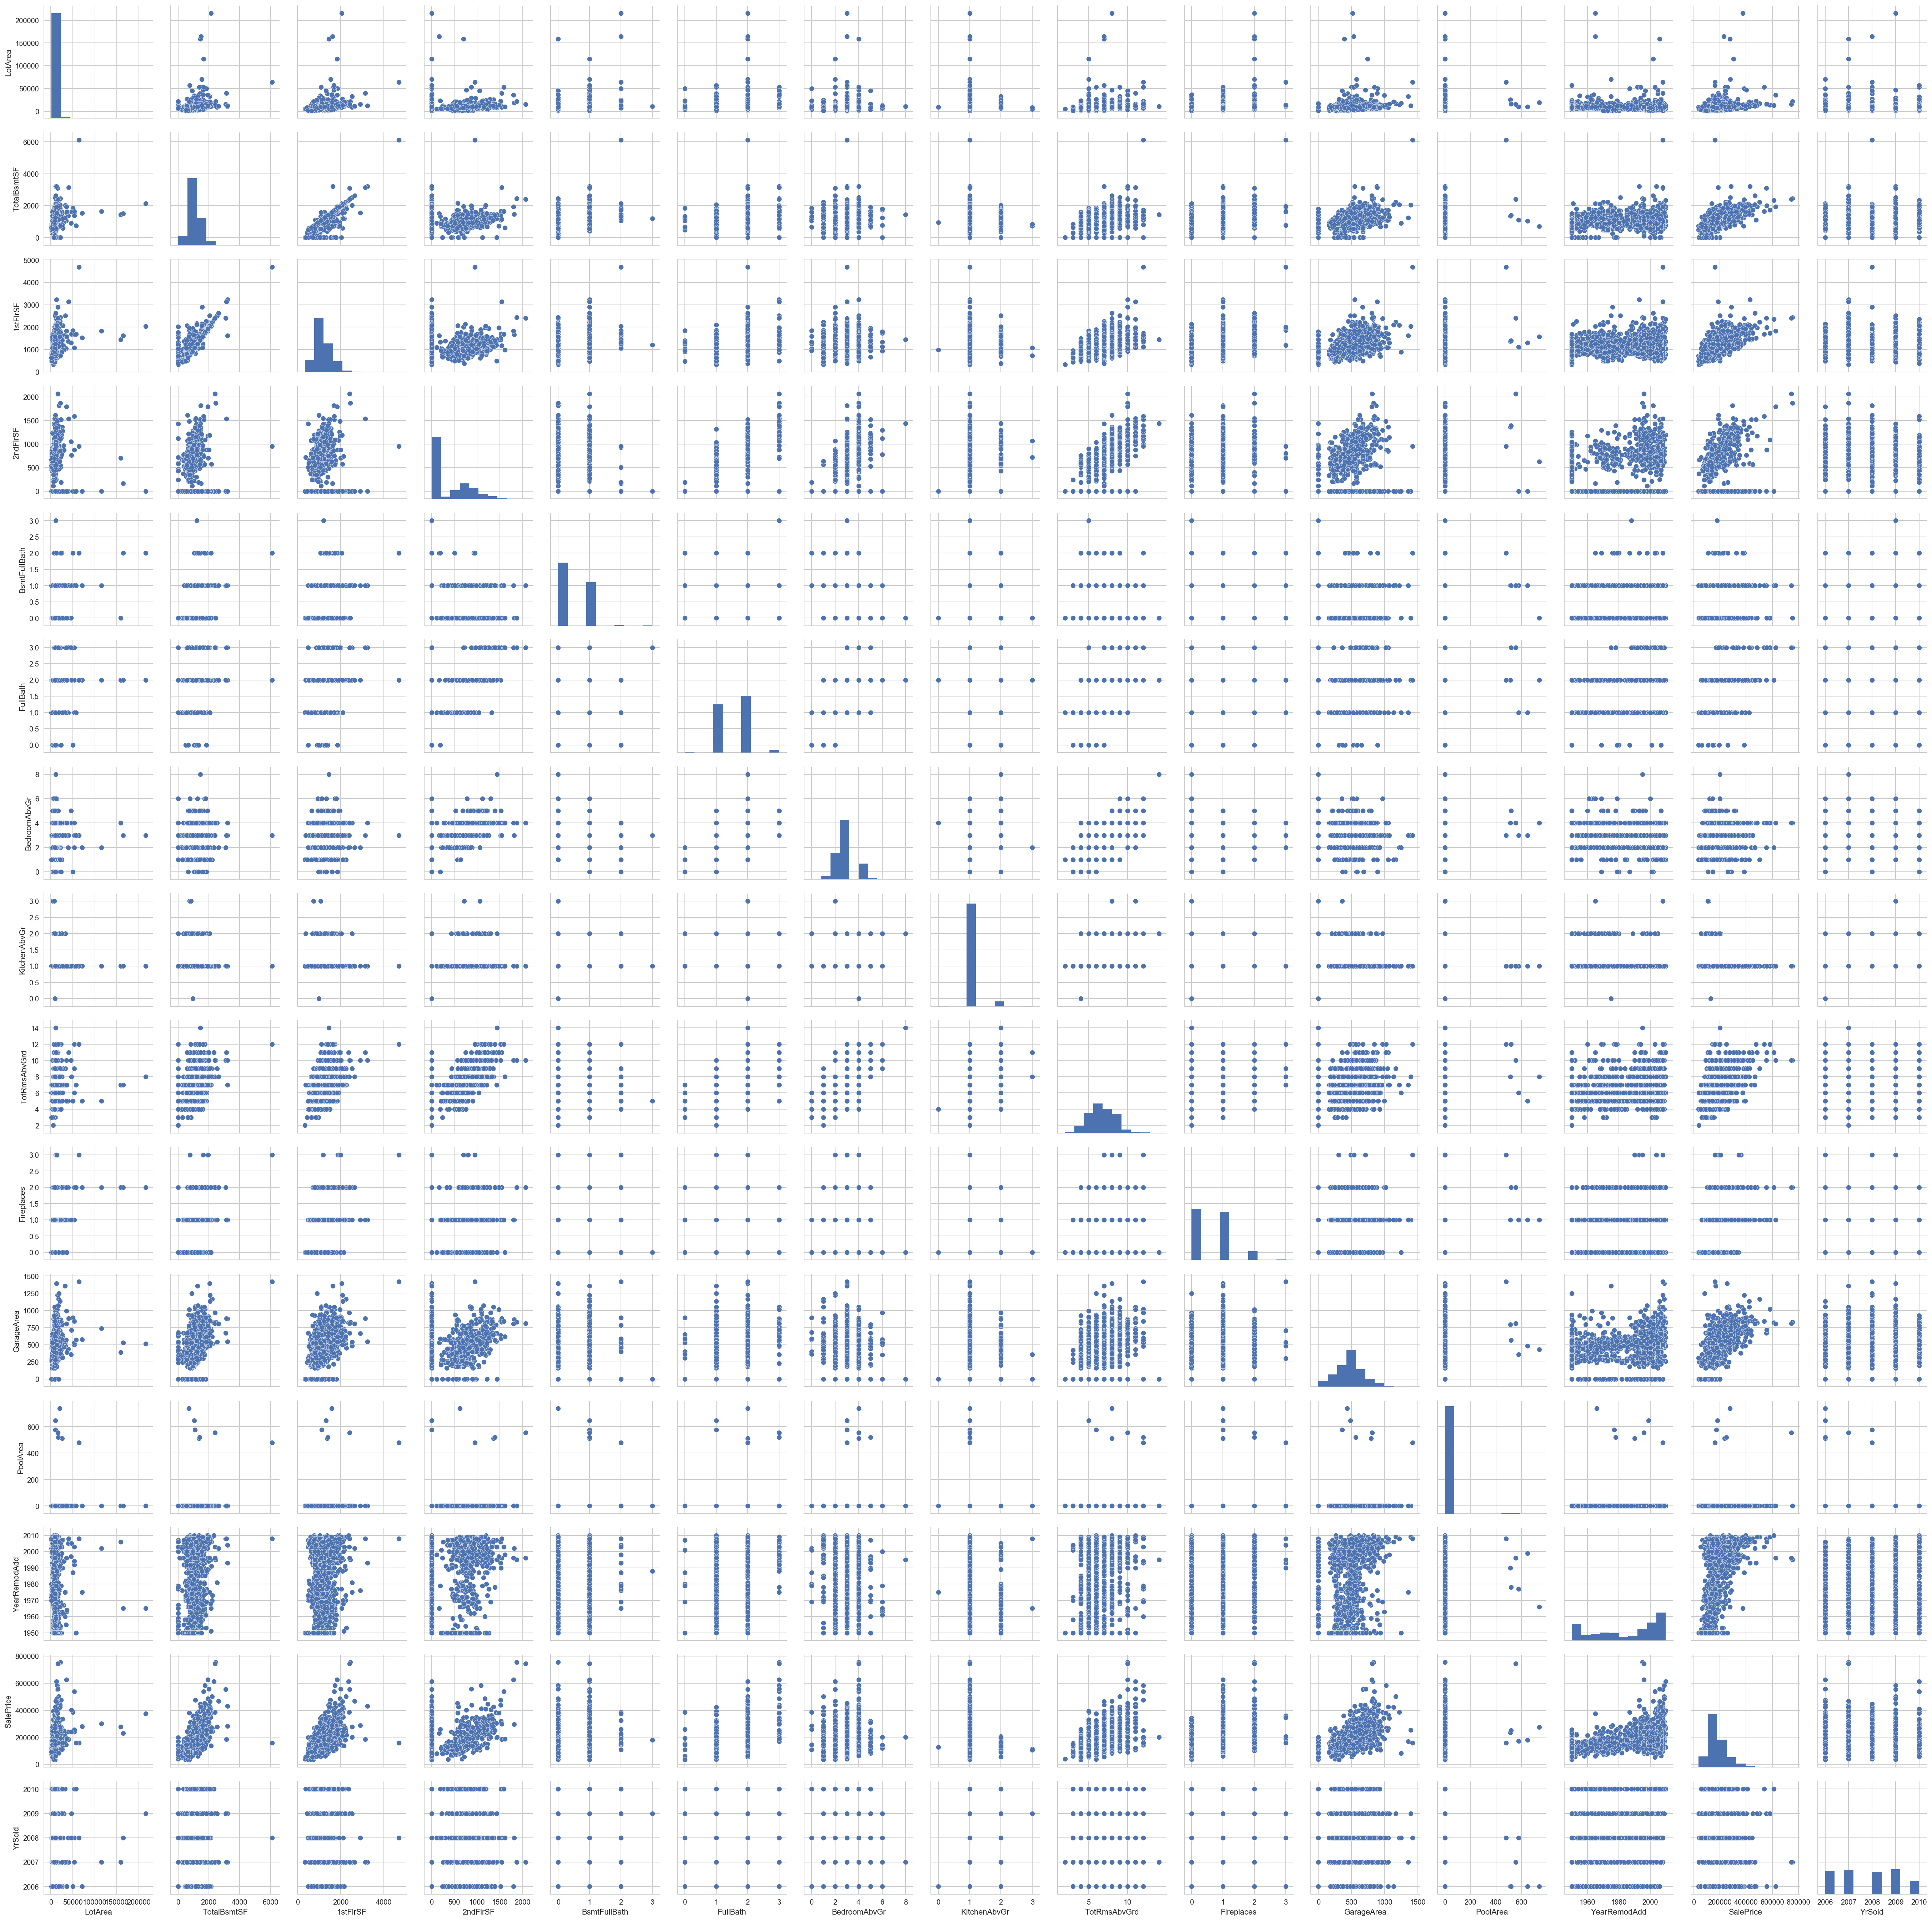

In [242]:
# I can see linear relationship between 'SalePrice' and fixed features from this pairplot
# Even categorical variables show linear relationship with price feature
# I assume that linear regression could be an effectrive price prediction model in this case
sns.pairplot(ndf)

In [18]:
# seems like most of fixed features(which can not be changed in short term) are correlated with SalesPrice 
ndf.corr()

,LotArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,BsmtFullBath,FullBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,YearRemodAdd,SalePrice,YrSold
LotArea,1.000000,0.260833,0.299475,0.050986,0.158155,0.126031,0.119690,-0.017784,0.190015,0.271364,0.180403,0.077672,0.013788,0.263843,-0.014261
TotalBsmtSF,0.260833,1.000000,0.819530,-0.174512,0.307351,0.323722,0.050450,-0.068901,0.285573,0.339519,0.486665,0.126053,0.291066,0.613581,-0.014969
1stFlrSF,0.299475,0.819530,1.000000,-0.202646,0.244671,0.380637,0.127401,0.068101,0.409516,0.410531,0.489782,0.131525,0.240379,0.605852,-0.013604
2ndFlrSF,0.050986,-0.174512,-0.202646,1.000000,-0.169494,0.421378,0.502901,0.059306,0.616423,0.194561,0.138347,0.081487,0.140024,0.319334,-0.028700
BsmtFullBath,0.158155,0.307351,0.244671,-0.169494,1.000000,-0.064512,-0.150673,-0.041503,-0.053275,0.137928,0.179189,0.067616,0.119470,0.227122,0.067049
FullBath,0.126031,0.323722,0.380637,0.421378,-0.064512,1.000000,0.363252,0.133115,0.554784,0.243671,0.405656,0.049604,0.439046,0.560664,-0.019669
BedroomAbvGr,0.119690,0.050450,0.127401,0.502901,-0.150673,0.363252,1.000000,0.198597,0.676620,0.107570,0.065253,0.070703,-0.040581,0.168213,-0.036014
KitchenAbvGr,-0.017784,-0.068901,0.068101,0.059306,-0.041503,0.133115,0.198597,1.000000,0.256045,-0.123936,-0.064433,-0.014525,-0.149598,-0.135907,0.031687
TotRmsAbvGrd,0.190015,0.285573,0.409516,0.616423,-0.053275,0.554784,0.676620,0.256045,1.000000,0.326114,0.337822,0.083757,0.191740,0.533723,-0.034516
Fireplaces,0.271364,0.339519,0.410531,0.194561,0.137928,0.243671,0.107570,-0.123936,0.326114,1.000000,0.269141,0.095074,0.112581,0.466929,-0.024096


In [19]:
# I am going to build a multivariate linear regression model with this new dataframe
# target = ndf["SalePrice"]
# predictors => the rest of the columns of the ndf(fe)
# However, I need to do some feature engineering for the columns
# which consist of categorical values
ndf.head()

,LotArea,LandContour,LotConfig,LandSlope,Neighborhood,BldgType,HouseStyle,Foundation,TotalBsmtSF,1stFlrSF,...,FullBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,PoolArea,YearRemodAdd,SalePrice,YrSold
0,8450,Lvl,Inside,Gtl,CollgCr,1Fam,2Story,PConc,856,856,...,2,3,1,8,0,548,0,2003,208500,2008
1,9600,Lvl,FR2,Gtl,Veenker,1Fam,1Story,CBlock,1262,1262,...,2,3,1,6,1,460,0,1976,181500,2007
2,11250,Lvl,Inside,Gtl,CollgCr,1Fam,2Story,PConc,920,920,...,2,3,1,6,1,608,0,2002,223500,2008
3,9550,Lvl,Corner,Gtl,Crawfor,1Fam,2Story,BrkTil,756,961,...,1,3,1,7,1,642,0,1970,140000,2006
4,14260,Lvl,FR2,Gtl,NoRidge,1Fam,2Story,PConc,1145,1145,...,2,4,1,9,1,836,0,2000,250000,2008


In [20]:
#create dummy variables for columns with categorical values
import pandas as pd
LandContour_dummy = pd.get_dummies(ndf['LandContour'], prefix = 'LandContour')
LotConfig_dummy = pd.get_dummies(ndf['LotConfig'], prefix = 'LotConfig')
LandSlope_dummy = pd.get_dummies(ndf['LandSlope'], prefix = 'LandSlope')
Neighborhood_dummy = pd.get_dummies(ndf['Neighborhood'], prefix = 'Neighborhood')
BldgType_dummy = pd.get_dummies(ndf['BldgType'], prefix = 'BldgType')
HouseStyle_dummy = pd.get_dummies(ndf['HouseStyle'], prefix = 'HouseStyle')
Foundation_dummy = pd.get_dummies(ndf['Foundation'], prefix = 'Foundation')

In [21]:
#concatenate dummy variables to ndf
dummies = pd.concat([LandContour_dummy,LotConfig_dummy,LandSlope_dummy,Neighborhood_dummy,BldgType_dummy, HouseStyle_dummy, Foundation_dummy], axis=1)

In [22]:
ndf = pd.concat([ndf, dummies], axis=1, join_axes=[ndf.index])

In [23]:
ndf.columns

Index([u'LotArea', u'LandContour', u'LotConfig', u'LandSlope', u'Neighborhood',
       u'BldgType', u'HouseStyle', u'Foundation', u'TotalBsmtSF', u'1stFlrSF',
       u'2ndFlrSF', u'BsmtFullBath', u'FullBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'TotRmsAbvGrd', u'Fireplaces', u'GarageArea',
       u'PoolArea', u'YearRemodAdd', u'SalePrice', u'YrSold',
       u'LandContour_Bnk', u'LandContour_HLS', u'LandContour_Low',
       u'LandContour_Lvl', u'LotConfig_Corner', u'LotConfig_CulDSac',
       u'LotConfig_FR2', u'LotConfig_FR3', u'LotConfig_Inside',
       u'LandSlope_Gtl', u'LandSlope_Mod', u'LandSlope_Sev',
       u'Neighborhood_Blmngtn', u'Neighborhood_Blueste',
       u'Neighborhood_BrDale', u'Neighborhood_BrkSide',
       u'Neighborhood_ClearCr', u'Neighborhood_CollgCr',
       u'Neighborhood_Crawfor', u'Neighborhood_Edwards',
       u'Neighborhood_Gilbert', u'Neighborhood_IDOTRR',
       u'Neighborhood_MeadowV', u'Neighborhood_Mitchel', u'Neighborhood_NAmes',
       u'Neighbo

In [24]:
# remove the 'original categorical columns'
ndf = ndf.drop(['LandContour', 'LotConfig', 'LandSlope', 'Neighborhood' ,'BldgType', 'HouseStyle', 'Foundation'], 
               axis=1)

In [25]:
ndf.columns

Index([u'LotArea', u'TotalBsmtSF', u'1stFlrSF', u'2ndFlrSF', u'BsmtFullBath',
       u'FullBath', u'BedroomAbvGr', u'KitchenAbvGr', u'TotRmsAbvGrd',
       u'Fireplaces', u'GarageArea', u'PoolArea', u'YearRemodAdd',
       u'SalePrice', u'YrSold', u'LandContour_Bnk', u'LandContour_HLS',
       u'LandContour_Low', u'LandContour_Lvl', u'LotConfig_Corner',
       u'LotConfig_CulDSac', u'LotConfig_FR2', u'LotConfig_FR3',
       u'LotConfig_Inside', u'LandSlope_Gtl', u'LandSlope_Mod',
       u'LandSlope_Sev', u'Neighborhood_Blmngtn', u'Neighborhood_Blueste',
       u'Neighborhood_BrDale', u'Neighborhood_BrkSide',
       u'Neighborhood_ClearCr', u'Neighborhood_CollgCr',
       u'Neighborhood_Crawfor', u'Neighborhood_Edwards',
       u'Neighborhood_Gilbert', u'Neighborhood_IDOTRR',
       u'Neighborhood_MeadowV', u'Neighborhood_Mitchel', u'Neighborhood_NAmes',
       u'Neighborhood_NPkVill', u'Neighborhood_NWAmes',
       u'Neighborhood_NoRidge', u'Neighborhood_NridgHt',
       u'Neighborhood

In [26]:
ndf.shape

(1460, 71)

In [27]:
#split the data based on the year sold column(pre-2010 data and 2010 data)
train = ndf[ndf['YrSold'] < 2010 ]
test = ndf[ndf['YrSold'] == 2010 ]

In [28]:
#drop 'YrSold' column from the train & test df
train = train.drop('YrSold', axis = 1)
test = test.drop('YrSold', axis =1)

In [29]:
#split train and test data into X(predictors) & y(target) category
X_train = train.drop('SalePrice', axis =1)
X_test = test.drop('SalePrice', axis =1)
y_train = train['SalePrice']
y_test = test['SalePrice']

In [30]:
#multivariate linear regression with normalisation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

lin_reg = LinearRegression(normalize=True).fit(X_train, y_train)

In [31]:
lin_reg.get_params

<bound method LinearRegression.get_params of LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)>

In [32]:
lin_reg.predict(X_train)

array([ 210944.,  188416.,  218112., ...,  224256.,  187392.,  126976.])

In [33]:
lin_reg.score(X_train, y_train)

0.82346140403193901

In [34]:
lin_reg.score(X_test, y_test)

0.84435104441344855

In [36]:
# Seems like this multivariate linear regression works pretty good(score: 0.84).
# However, there is a problem of overfitting with too many features(72 features).
# I am going to apply regularization with Ridge, Lasso and elestic Net in order to prevent overfitting.

In [37]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score

In [38]:
#Ridge CV with normalization
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
ridge_cv = RidgeCV(alphas=alphas, cv = 5)

In [39]:
ridge_cv.fit(X_train, y_train)
ridge_cv.get_params()

{'alphas': [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75],
 'cv': 5,
 'fit_intercept': True,
 'gcv_mode': None,
 'normalize': False,
 'scoring': None,
 'store_cv_values': False}

In [41]:
ridge_cv.predict(X_train)

array([ 212619.67249338,  186928.8626612 ,  221073.54213136, ...,
        220555.37384041,  186927.72912319,  128888.60619046])

In [42]:
ridge_cv.coef_

array([  3.53510044e-01,   1.86208445e+01,   5.08115554e+01,
         7.47580804e+01,   1.14036251e+04,   8.45508643e+03,
        -8.63772243e+03,  -3.47014899e+04,   4.32440408e+03,
         9.37592852e+03,   3.04061448e+01,  -1.33681982e+01,
         4.28218093e+02,  -1.51597691e+04,   1.44324982e+04,
        -2.92713080e+02,   1.01998401e+03,   5.83296891e+01,
         1.37510482e+04,  -5.28018630e+03,  -1.07387021e+04,
         2.20951054e+03,   2.31416999e+03,   9.50512856e+03,
        -1.18192986e+04,  -7.07008535e+02,   1.13868577e+03,
         1.12742677e+04,  -1.06803828e+04,  -1.53939589e+04,
        -5.78715996e+03,   5.71853316e+03,  -2.82609470e+04,
        -1.57518368e+04,  -2.51069321e+04,  -8.69750555e+03,
        -2.02868883e+04,  -1.51843223e+04,   8.86437691e+03,
        -1.55626268e+04,   4.94845924e+04,   5.94755251e+04,
        -2.60616988e+04,  -1.62352668e+04,  -2.04901225e+04,
        -8.16319238e+03,   1.87806733e+04,   5.55949031e+04,
         1.79926698e+03,

In [43]:
ridge_cv.score(X_train, y_train)

0.82304271794756634

In [44]:
ridge_cv.score(X_test, y_test)

0.84596376797532646

In [45]:
#Lasso CV with cross validation
lasso_cv = LassoCV(alphas=alphas, cv=5)

In [46]:
lasso_cv.fit(X_train, y_train)
lasso_cv.get_params()

{'alphas': [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75],
 'copy_X': True,
 'cv': 5,
 'eps': 0.001,
 'fit_intercept': True,
 'max_iter': 1000,
 'n_alphas': 100,
 'n_jobs': 1,
 'normalize': False,
 'positive': False,
 'precompute': 'auto',
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'verbose': False}

In [47]:
lasso_cv.alpha_ # best alpha for lasso

50.0

In [48]:
lasso_cv.score(X_train, y_train)

0.82268658479583978

In [49]:
lasso_cv.score(X_test, y_test)

0.84454471046481083

In [50]:
#Elestic Net CV
elastic_net = ElasticNetCV(alphas=alphas, cv=5)

In [51]:
elastic_net.fit(X_train, y_train)

ElasticNetCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75],
       copy_X=True, cv=5, eps=0.001, fit_intercept=True, l1_ratio=0.5,
       max_iter=1000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0)

In [52]:
elastic_net.predict(X_train)

array([ 213262.57494555,  171901.51317673,  225175.19078837, ...,
        207192.39741368,  194888.70774554,  131551.16070112])

In [53]:
elastic_net.score(X_train, y_train)

0.80252926320898221

In [54]:
elastic_net.score(X_test, y_test)

0.83957829813895424

In [55]:
# I've got the highest score(0.845) with RidgeCV for fixed variables
# This means about 84.5 % of SalePrice can be predicted with this model

In [111]:
# Plotting 'Predicted & Real SalePrice gap' for fixed variables
real_price_test = y_test # dataframe
type(real_price_test)

pandas.core.series.Series

In [113]:
pred_price_test = ridge_cv.predict(X_test)

numpy.ndarray

In [114]:
price_gap_test = real_price_test - pred_price_test

pandas.core.series.Series

In [116]:
real_price_train = y_train

In [119]:
pred_price_train = ridge_cv.predict(X_train)
price_gap_train = real_price_train - pred_price_train

<Container object of 3 artists>

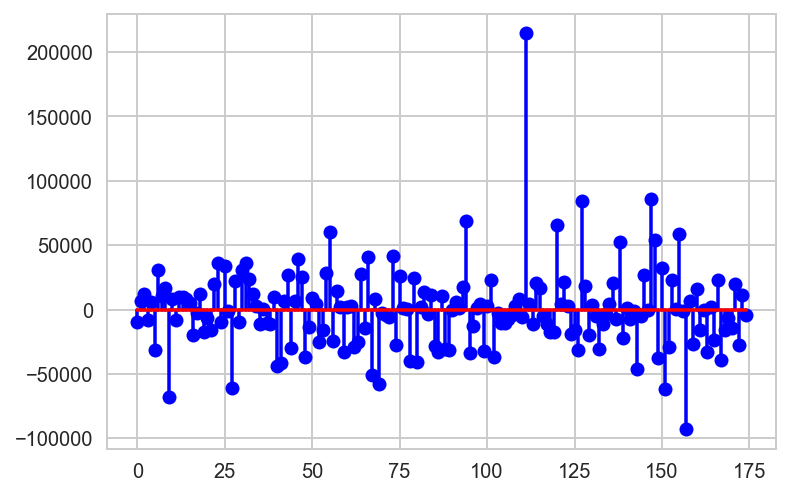

In [71]:
plt.stem(price_gap_test, linefmt='b-', markerfmt='bo', basefmt='r-')

In [639]:
# I can see some points with big price gaps(over 100k)
# I'll see how this model performs on renovatable features in #2.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [187]:
# [revonate-able features]
# I selected most of quality or condition columns for exterior, interior, electrical, heating part
# to see that renovating those parts can add more values to the houses.

reno_df = house[['ExterQual','ExterCond','HeatingQC','CentralAir','BsmtCond','Electrical',
                 'KitchenQual','GarageQual','GarageCond','FireplaceQu','Fence',
                'RoofStyle', 'MasVnrType', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF']]

# I didn't include 'PoolQC'(w/ 7 non-null) and 'MiscFeature'(w/ 54 non-null) 
# because they mostly consist of null values 


In [188]:
# I'll not impute NaN values for categorical columns because
# first most of the columns don't have many NaN variables(except fot 'FirePlaceQu' & 'Fence' )
# and pandas'get_dummies' method will ignore them.
reno_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 16 columns):
ExterQual      1460 non-null object
ExterCond      1460 non-null object
HeatingQC      1460 non-null object
CentralAir     1460 non-null object
BsmtCond       1423 non-null object
Electrical     1459 non-null object
KitchenQual    1460 non-null object
GarageQual     1379 non-null object
GarageCond     1379 non-null object
FireplaceQu    770 non-null object
Fence          281 non-null object
RoofStyle      1460 non-null object
MasVnrType     1452 non-null object
PavedDrive     1460 non-null object
WoodDeckSF     1460 non-null int64
OpenPorchSF    1460 non-null int64
dtypes: int64(2), object(14)
memory usage: 182.6+ KB


In [189]:
reno_df.columns

Index([u'ExterQual', u'ExterCond', u'HeatingQC', u'CentralAir', u'BsmtCond',
       u'Electrical', u'KitchenQual', u'GarageQual', u'GarageCond',
       u'FireplaceQu', u'Fence', u'RoofStyle', u'MasVnrType', u'PavedDrive',
       u'WoodDeckSF', u'OpenPorchSF'],
      dtype='object')

In [190]:
# Create dummy variables

ExterQual_dummy = pd.get_dummies(reno_df['ExterQual'], prefix = 'ExterQual')
ExterCond_dummy = pd.get_dummies(reno_df['ExterCond'], prefix = 'ExterCond')
HeatingQC_dummy = pd.get_dummies(reno_df['HeatingQC'], prefix = 'HeatingQC')
CentralAir_dummy = pd.get_dummies(reno_df['CentralAir'], prefix = 'CentralAir')
BsmtCond_dummy = pd.get_dummies(reno_df['BsmtCond'], prefix = 'BsmtCond')
Electrical_dummy = pd.get_dummies(reno_df['Electrical'], prefix = 'Electrical')
KitchenQual_dummy = pd.get_dummies(reno_df['KitchenQual'], prefix = 'KitchenQual')
GarageQual_dummy = pd.get_dummies(reno_df['GarageQual'], prefix = 'GarageQual')
GarageCond_dummy = pd.get_dummies(reno_df['GarageCond'], prefix = 'GarageCond')
FireplaceQu_dummy = pd.get_dummies(reno_df['FireplaceQu'], prefix = 'FireplaceQu')
Fence_dummy = pd.get_dummies(reno_df['Fence'], prefix = 'Fence')
MasVnrType_dummy = pd.get_dummies(reno_df['MasVnrType'], prefix = 'MasVnrType')
RoofStyle_dummy = pd.get_dummies(reno_df['RoofStyle'], prefix = 'RoofStyle')
PavedDrive_dummy = pd.get_dummies(reno_df['PavedDrive'], prefix = 'PavedDrive')

In [191]:
dummies = pd.concat([ExterQual_dummy,ExterCond_dummy,HeatingQC_dummy,CentralAir_dummy, BsmtCond_dummy,
                     Electrical_dummy, KitchenQual_dummy, GarageQual_dummy, GarageCond_dummy,
                     FireplaceQu_dummy, Fence_dummy, MasVnrType_dummy, RoofStyle_dummy, PavedDrive_dummy ], axis=1)

In [192]:
reno_df.head()

,ExterQual,ExterCond,HeatingQC,CentralAir,BsmtCond,Electrical,KitchenQual,GarageQual,GarageCond,FireplaceQu,Fence,RoofStyle,MasVnrType,PavedDrive,WoodDeckSF,OpenPorchSF
0,Gd,TA,Ex,Y,TA,SBrkr,Gd,TA,TA,NaN,NaN,Gable,BrkFace,Y,0,61
1,TA,TA,Ex,Y,TA,SBrkr,TA,TA,TA,TA,NaN,Gable,None,Y,298,0
2,Gd,TA,Ex,Y,TA,SBrkr,Gd,TA,TA,TA,NaN,Gable,BrkFace,Y,0,42
3,TA,TA,Gd,Y,Gd,SBrkr,Gd,TA,TA,Gd,NaN,Gable,None,Y,0,35
4,Gd,TA,Ex,Y,TA,SBrkr,Gd,TA,TA,TA,NaN,Gable,BrkFace,Y,192,84


In [193]:
reno_df = pd.concat([reno_df, dummies], axis=1, join_axes=[reno_df.index])

In [194]:
# drop origianl categorical columns
reno_df = reno_df.drop([u'ExterQual', u'ExterCond', u'HeatingQC', u'CentralAir', u'BsmtCond',
                        u'Electrical', u'KitchenQual', u'GarageQual', u'GarageCond', u'FireplaceQu', 
                        u'Fence', u'MasVnrType', u'RoofStyle', u'PavedDrive'], axis=1)

In [195]:
wdf = pd.concat([ndf, reno_df], axis=1)

In [196]:
wdf.head()

,LotArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,BsmtFullBath,FullBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,...,MasVnrType_Stone,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,PavedDrive_N,PavedDrive_P,PavedDrive_Y
0,8450,856,856,854,1,2,3,1,8,0,...,0,0,1,0,0,0,0,0,0,1
1,9600,1262,1262,0,0,2,3,1,6,1,...,0,0,1,0,0,0,0,0,0,1
2,11250,920,920,866,1,2,3,1,6,1,...,0,0,1,0,0,0,0,0,0,1
3,9550,756,961,756,1,1,3,1,7,1,...,0,0,1,0,0,0,0,0,0,1
4,14260,1145,1145,1053,1,2,4,1,9,1,...,0,0,1,0,0,0,0,0,0,1


In [197]:
wdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 134 entries, LotArea to PavedDrive_Y
dtypes: int64(17), uint8(117)
memory usage: 360.8 KB


In [198]:
wdf.shape

(1460, 134)

In [199]:
columns = wdf.columns
cols=[]
for col in columns:
    cols.append(col)
cols

['LotArea',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'BsmtFullBath',
 'FullBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageArea',
 'PoolArea',
 'YearRemodAdd',
 'SalePrice',
 'YrSold',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Gtl',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Neighborhood_Blmngtn',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_OldTown',
 'Neighborhood_SWISU',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Somerst',
 'Ne

In [200]:
#split the data based on the year sold column(pre-2010 data and 2010 data)
train = wdf[wdf['YrSold'] < 2010 ]
test = wdf[wdf['YrSold'] == 2010 ]
#drop 'YrSold' column from the train & test df
train = train.drop('YrSold', axis = 1)
test = test.drop('YrSold', axis =1)
#split train and test data into X(predictors) & y(target) category
X_train = train.drop('SalePrice', axis =1)
X_test = test.drop('SalePrice', axis =1)
y_train = train['SalePrice']
y_test = test['SalePrice']

In [201]:
train.head()

,LotArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,BsmtFullBath,FullBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,...,MasVnrType_Stone,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,PavedDrive_N,PavedDrive_P,PavedDrive_Y
0,8450,856,856,854,1,2,3,1,8,0,...,0,0,1,0,0,0,0,0,0,1
1,9600,1262,1262,0,0,2,3,1,6,1,...,0,0,1,0,0,0,0,0,0,1
2,11250,920,920,866,1,2,3,1,6,1,...,0,0,1,0,0,0,0,0,0,1
3,9550,756,961,756,1,1,3,1,7,1,...,0,0,1,0,0,0,0,0,0,1
4,14260,1145,1145,1053,1,2,4,1,9,1,...,0,0,1,0,0,0,0,0,0,1


In [202]:
test.head()

,LotArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,BsmtFullBath,FullBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,...,MasVnrType_Stone,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,PavedDrive_N,PavedDrive_P,PavedDrive_Y
16,11241,1004,1004,0,1,1,2,1,5,1,...,0,0,1,0,0,0,0,0,0,1
24,8246,1060,1060,0,1,1,3,1,6,1,...,0,0,1,0,0,0,0,0,0,1
26,7200,900,900,0,0,1,3,1,5,0,...,0,0,1,0,0,0,0,0,0,1
27,11478,1704,1704,0,1,2,3,1,7,1,...,1,0,1,0,0,0,0,0,0,1
33,10552,1398,1700,0,0,1,4,1,6,1,...,0,0,0,0,1,0,0,0,0,1


In [203]:
# I'll use linear regression and reguralized linear regression models
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [204]:
lin_reg.predict(X_train)

array([ 211712.,  192768.,  215808., ...,  215552.,  174848.,  143616.])

In [205]:
lin_reg.score(X_train, y_train)        

0.85496440068061497

In [206]:
# this linear regression model doesn't work well on the test datasets.
# this could happen because of overfitting.(128 features)
lin_reg.score(X_test, y_test)

-5.1928284149453148e+24

In [207]:
# reguralized linear regression models

# ridge cv
ridge_cv.fit(X_train, y_train)
ridge_cv.score(X_train, y_train)

0.85026359045309119

In [208]:
ridge_cv.score(X_test, y_test)

0.87422622049519783

In [209]:
# lasso cv
lasso_cv.fit(X_train, y_train)

LassoCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75], copy_X=True,
    cv=5, eps=0.001, fit_intercept=True, max_iter=1000, n_alphas=100,
    n_jobs=1, normalize=False, positive=False, precompute='auto',
    random_state=None, selection='cyclic', tol=0.0001, verbose=False)

In [210]:
lasso_cv.score(X_train, y_train)

0.84848570031877912

In [211]:
lasso_cv.score(X_test, y_test)

0.87496851221439753

In [212]:
lasso_cv.coef_

array([  3.55798004e-01,   1.10670369e+01,   4.47374735e+01,
         6.06126975e+01,   1.00709375e+04,   9.72129198e+03,
        -4.19211091e+03,  -2.47521226e+04,   2.10708363e+03,
         6.94473175e+03,   2.51945335e+01,  -1.60283486e+01,
         2.87062206e+02,  -1.54583001e+04,   9.60945099e+03,
         0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00,
         1.25165935e+04,  -6.52404529e+03,  -0.00000000e+00,
         6.79994369e+02,   0.00000000e+00,   7.54641194e+03,
        -5.91231707e+03,   0.00000000e+00,   0.00000000e+00,
         1.80303608e+03,  -4.39467013e+02,  -2.69608769e+03,
         8.74695861e+02,   1.66234940e+04,  -2.12401900e+04,
        -2.56264914e+03,  -1.23144390e+04,  -3.18281952e+03,
        -7.50485155e+03,  -5.54134610e+03,   5.82052829e+03,
        -2.84056852e+03,   6.25205081e+04,   4.14072855e+04,
        -1.62636602e+04,  -3.20263673e+03,  -8.82247359e+03,
         0.00000000e+00,   1.91076576e+04,   5.37674276e+04,
         6.65664098e+03,

In [213]:
lasso_cv.predict(X_train)

array([ 209962.18303313,  180926.34220113,  216410.85918802, ...,
        207327.70415418,  176743.43245752,  147068.48809191])

In [214]:
# Ridge_cv got the best model for this case(87.8%) compared to the score only with the  fixed variables(84.5%)
# This means there must be some price increases after renovation

In [215]:
real_price_2 = y_test
pred_price_2 = ridge_cv.predict(X_test)
price_gap_2 = real_price_2 - pred_price_2

<Container object of 3 artists>

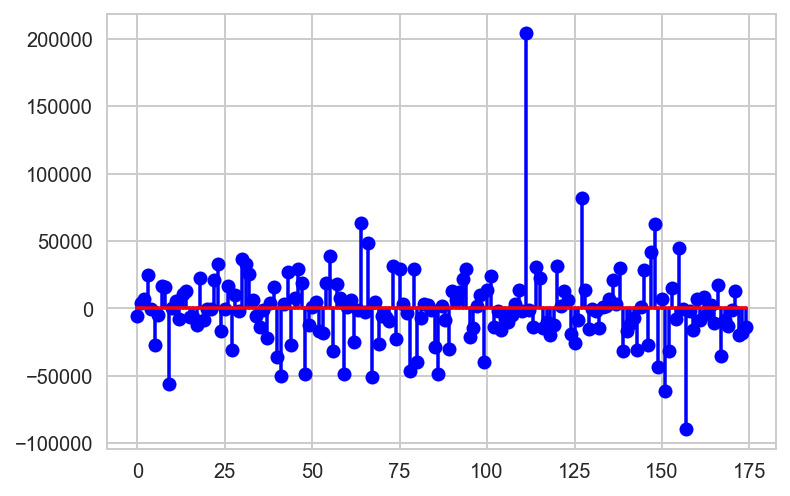

In [216]:
# Plotting 'Predicted & Real SalePrice gap' for the fixed and renovatable variables
# Compared to the price gap graph only with the fixed variables, gaps has definitely decreased.
# There's still some outliers(huge price gaps) in this graph and I assume that these units might be very different
# in terms of types of sales and other factors that were not dealt with in this analysis.
plt.stem(price_gap_2, linefmt='b-', markerfmt='bo', basefmt='r-')

In [217]:
# Since I confirmed that the renovatable features increases the possibility of predicting sales prices,
# I'd like to see the effect of renovatable features on the variance(price gap) of #1
# so that I can explain the effect of changeable variables in dollars
# In this model, my target would be 'price gaps' between predicted price and real sales price
reno_yr_df = pd.concat([reno_df, wdf['YrSold']], axis=1)

In [218]:
#split the data based on the year sold column(pre-2010 data and 2010 data)
train = reno_yr_df[reno_yr_df['YrSold'] < 2010 ]
test = reno_yr_df[reno_yr_df['YrSold'] == 2010 ]
#drop 'YrSold' column from the train & test df
train = train.drop('YrSold', axis = 1)
test = test.drop('YrSold', axis =1)
#split train and test data into X(predictors) & y(target) category
X_train = pd.concat([train], axis=1)
X_test = pd.concat([test], axis=1)
# I set the squared price gap as my target because if I set the price gap(not squared) my model,
# I cannot see how renovatable variables(predictors) have an impact on 
y_train = (price_gap_train * price_gap_train)
y_test = (price_gap_test * price_gap_test)

In [219]:
#fit my model(Ridge_CV) with the reno_df

In [220]:
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75], cv=5,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [221]:
ridge_cv.score(X_train, y_train)

0.10675190600291551

In [222]:
X_test.columns

Index([u'WoodDeckSF', u'OpenPorchSF', u'ExterQual_Ex', u'ExterQual_Fa',
       u'ExterQual_Gd', u'ExterQual_TA', u'ExterCond_Ex', u'ExterCond_Fa',
       u'ExterCond_Gd', u'ExterCond_Po', u'ExterCond_TA', u'HeatingQC_Ex',
       u'HeatingQC_Fa', u'HeatingQC_Gd', u'HeatingQC_Po', u'HeatingQC_TA',
       u'CentralAir_N', u'CentralAir_Y', u'BsmtCond_Fa', u'BsmtCond_Gd',
       u'BsmtCond_Po', u'BsmtCond_TA', u'Electrical_FuseA',
       u'Electrical_FuseF', u'Electrical_FuseP', u'Electrical_Mix',
       u'Electrical_SBrkr', u'KitchenQual_Ex', u'KitchenQual_Fa',
       u'KitchenQual_Gd', u'KitchenQual_TA', u'GarageQual_Ex',
       u'GarageQual_Fa', u'GarageQual_Gd', u'GarageQual_Po', u'GarageQual_TA',
       u'GarageCond_Ex', u'GarageCond_Fa', u'GarageCond_Gd', u'GarageCond_Po',
       u'GarageCond_TA', u'FireplaceQu_Ex', u'FireplaceQu_Fa',
       u'FireplaceQu_Gd', u'FireplaceQu_Po', u'FireplaceQu_TA', u'Fence_GdPrv',
       u'Fence_GdWo', u'Fence_MnPrv', u'Fence_MnWw', u'MasVnrType_BrkCmn

In [255]:
ridge_cv.score(X_test, y_test)

0.10197777330347968

In [256]:
# renovatable features corresponding to each coefficient 

In [257]:
cols = reno_yr_df.columns
coefs = ridge_cv.coef_

In [258]:
col_names =[]
for i in range(63):
    col_names.append(cols[i])

col_names
   

['WoodDeckSF',
 'OpenPorchSF',
 'ExterQual_Ex',
 'ExterQual_Fa',
 'ExterQual_Gd',
 'ExterQual_TA',
 'ExterCond_Ex',
 'ExterCond_Fa',
 'ExterCond_Gd',
 'ExterCond_Po',
 'ExterCond_TA',
 'HeatingQC_Ex',
 'HeatingQC_Fa',
 'HeatingQC_Gd',
 'HeatingQC_Po',
 'HeatingQC_TA',
 'CentralAir_N',
 'CentralAir_Y',
 'BsmtCond_Fa',
 'BsmtCond_Gd',
 'BsmtCond_Po',
 'BsmtCond_TA',
 'Electrical_FuseA',
 'Electrical_FuseF',
 'Electrical_FuseP',
 'Electrical_Mix',
 'Electrical_SBrkr',
 'KitchenQual_Ex',
 'KitchenQual_Fa',
 'KitchenQual_Gd',
 'KitchenQual_TA',
 'GarageQual_Ex',
 'GarageQual_Fa',
 'GarageQual_Gd',
 'GarageQual_Po',
 'GarageQual_TA',
 'GarageCond_Ex',
 'GarageCond_Fa',
 'GarageCond_Gd',
 'GarageCond_Po',
 'GarageCond_TA',
 'FireplaceQu_Ex',
 'FireplaceQu_Fa',
 'FireplaceQu_Gd',
 'FireplaceQu_Po',
 'FireplaceQu_TA',
 'Fence_GdPrv',
 'Fence_GdWo',
 'Fence_MnPrv',
 'Fence_MnWw',
 'MasVnrType_BrkCmn',
 'MasVnrType_BrkFace',
 'MasVnrType_None',
 'MasVnrType_Stone',
 'RoofStyle_Flat',
 'RoofStyle_

In [259]:
coefs

array([  2.78060557e+06,   1.12560679e+07,   1.60815258e+09,
        -9.61520179e+07,  -7.62155473e+08,  -7.49845091e+08,
        -1.36350073e+08,   1.06807723e+07,   1.28367242e+08,
         0.00000000e+00,  -2.69794121e+06,   1.12726434e+08,
        -5.57058806e+07,  -4.89856138e+06,   3.15194433e+06,
        -5.52739362e+07,   1.39052755e+07,  -1.39052755e+07,
         2.27100292e+06,  -3.51674125e+08,   4.50664618e+06,
         2.06463177e+08,   2.37821522e+07,   5.67766894e+07,
         3.04022041e+06,   1.24422548e+07,  -1.04811894e+08,
         1.42188565e+09,  -1.12540051e+08,  -7.70131170e+08,
        -5.39214432e+08,   1.44834116e+08,  -7.86903845e+07,
        -7.14289426e+07,   8.43394267e+06,  -4.66486325e+07,
        -1.31278219e+07,   5.30131802e+07,  -4.53260567e+07,
        -4.67890126e+07,   8.72980968e+06,   1.96826689e+08,
        -1.08127914e+08,   2.90797136e+08,   1.01476549e+06,
         1.91013372e+08,   1.40997685e+06,  -2.79821813e+07,
         2.01307215e+08,

In [262]:
dic = {}
for k, v in zip(col_names, coefs):
    dic[k] = v
dic

{'BsmtCond_Fa': 2271002.917050051,
 'BsmtCond_Gd': -351674125.16676211,
 'BsmtCond_Po': 4506646.1763110422,
 'BsmtCond_TA': 206463177.35852987,
 'CentralAir_N': 13905275.538359953,
 'CentralAir_Y': -13905275.538360214,
 'Electrical_FuseA': 23782152.228052367,
 'Electrical_FuseF': 56776689.384678051,
 'Electrical_FuseP': 3040220.4086076561,
 'Electrical_Mix': 12442254.806838,
 'Electrical_SBrkr': -104811893.69301042,
 'ExterCond_Ex': -136350073.43835655,
 'ExterCond_Fa': 10680772.323111912,
 'ExterCond_Gd': 128367242.32440147,
 'ExterCond_Po': 0.0,
 'ExterCond_TA': -2697941.2091569067,
 'ExterQual_Ex': 1608152581.7600932,
 'ExterQual_Fa': -96152017.879762843,
 'ExterQual_Gd': -762155472.94356489,
 'ExterQual_TA': -749845090.9367646,
 'Fence_GdPrv': 1409976.847428262,
 'Fence_GdWo': -27982181.30012764,
 'Fence_MnPrv': 201307214.69092417,
 'Fence_MnWw': -104362787.74630815,
 'FireplaceQu_Ex': 196826689.16535509,
 'FireplaceQu_Fa': -108127913.67804423,
 'FireplaceQu_Gd': 290797136.35526395

In [263]:
# coefficient of KitchenQual_Excellent feature
# the effect of 'KitchenQual_Excellent' feature could be calculated by coefficient **(.5)
# because this coefficient was calculated with variance(squared price gap)
1421885653.442378 ** (.5)

37707.899085501675

In [261]:
# got about 0.10 for R^2 score with Ridge CV
# This means the changeable features can describe about 10% of the variance of the price(real price - predicted price)
# The effect of changeable features can be interpreted as the effect in dollars as well
# We can interpret the coefficients of my model(Ridge regression) correspinding to the renovable variables 
# For example, when the company renovates kitchen with new materials 
# and increases the quality to the excellent level, 
# it will increase the value of the unit by 37,707 US dollars and ctaully it make sense in reality

# However, some coefficients cannot be explained well in reality (e.g.: 'ExterCond_Ex': -136350073.43835655)
# If you upgrade the quality of the exterior and increase its grade up to the excellent level,
# it will result in decreasing values according to this model.

# I think I could improve model if I have more time for this project in a way of labeling categorial features which
# could be graded(e.g: Ex:5, Gd:4, TA:3, Fa:2, Po:1, NA:0). I assume this will give me a better result

# Therefore, this second model for renovatable variables should be interpreted with the fist model for renovatable 
# variables which concluded that renovatable variables could increase the values of units overall 

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [5]:
# A: